In [44]:
import json
import random
import numpy as np
import shutil
import os
import glob
from pathlib import Path
from operator import itemgetter 
from itertools import groupby
from os.path import exists
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import figure
import matplotlib.pyplot as plt

random.seed(42)

In [95]:
metadata_path = 'C:\Projects\wild\data\ENA24\ena24_public.json'
ena_local_base = r'c:/temp/ena/images/'

In [3]:
NUM_EMPTY, NUM_NONEMPTY = 10, 10

In [94]:
with open(metadata_path) as f:
    d = json.load(f)

### human labels removed -> change american black bear to 22

In [97]:
d['categories'][-1]['id'] = 8
for anno in d['annotations']:
    if anno.get('category_id') == 22:
        anno['category_id'] = 8

In [98]:
for i in range(len(d['images'])):
    d['images'][i]['image_id'] = d['images'][i].pop('id')

my_id = itemgetter('image_id')
meta_anno = []

for k, v in groupby(sorted((d['annotations'] + d['images']), key=my_id), key=my_id):
    meta_anno.append({key:val for d in v for key, val in d.items()})

In [99]:
missing_ids = set()
for idx, image in enumerate(meta_anno):
    if not image.get('category_id'):
        missing_ids.add(image['image_id'])
print('number of missing ids: {}'.format(len(missing_ids)))
meta_anno = [img for img in meta_anno if img.get('image_id') not in missing_ids]

number of missing ids: 200


In [14]:
def filter_species():
    pass

def filter_locations():
    pass

In [38]:
# https://www.statology.org/seaborn-barplot-show-values/
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

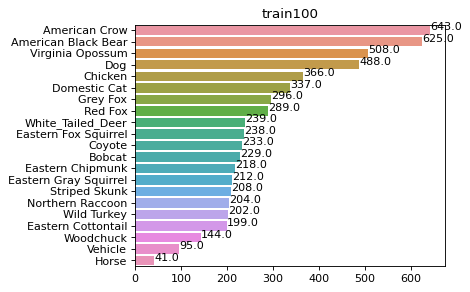

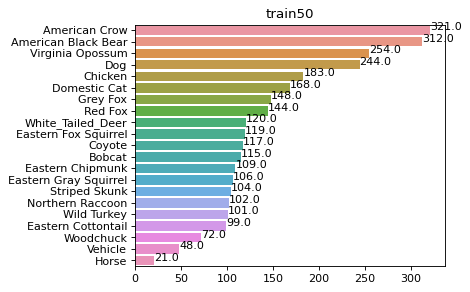

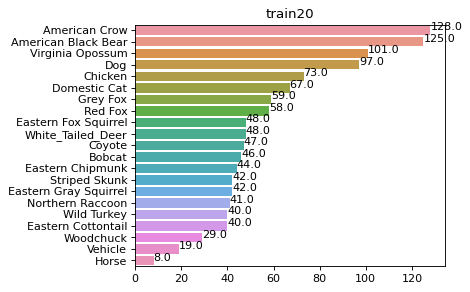

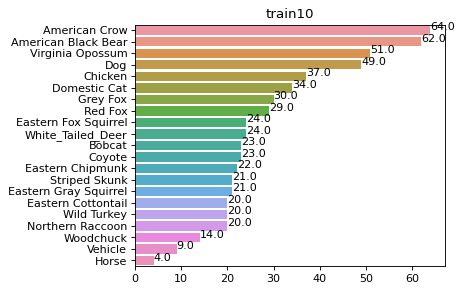

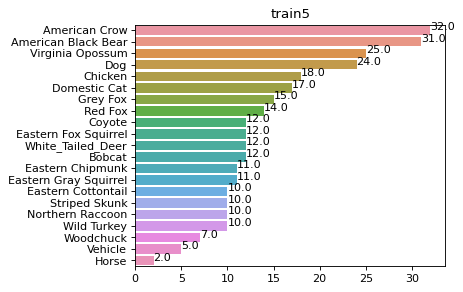

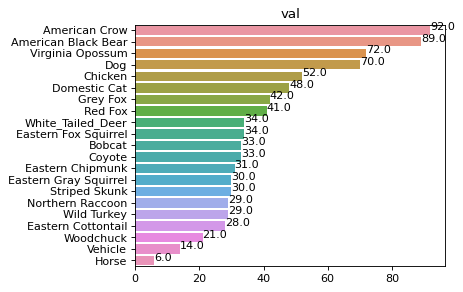

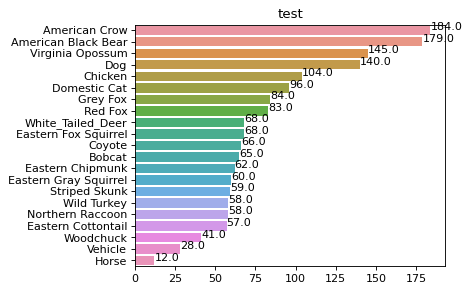

In [83]:
for subset, name in zip(trainsubsets + [validate, test], ('train100', 'train50', 'train20', 'train10', 'train5', "val", "test")):
    location_counter = {}
    sequence_counter = {}
    species_counter = {}

    for img in subset:
        location_counter[img.get('location')] = location_counter.get(img.get('location'), 0) + 1
        sequence_counter[img.get('seq_num_frames')] = sequence_counter.get(img.get('seq_num_frames'), 0) + 1
        species_counter[img.get('category_id')] = species_counter.get(img.get('category_id'), 0) + 1

    species_lookup = {i.get('id') : i.get('name') for i in d['categories']}
    species_named_counter = {species_lookup.get(k): v for k, v in species_counter.items()}

    plt.figure(num=None, figsize=(5,4), dpi=80, facecolor='w', edgecolor='r')
    y = list(species_named_counter.keys())
    x = list(species_named_counter.values())
    argx = np.argsort(x)[::-1]
    x = np.array(x)[argx]
    y = np.array(y)[argx]
    plt.title(name)
    p = sns.barplot(x = x, y = y)
    show_values(p, "h", space=0)
    plt.show()

In [57]:
full_length = len(meta_anno)
labels = [i.get('category_id') for i in meta_anno]
train, test = train_test_split(meta_anno, test_size=(full_length//5), random_state=42, stratify=labels)
labels = [i.get('category_id') for i in train]
train, validate = train_test_split(train, test_size=(full_length//10), random_state=44, stratify=labels)
labels = [i.get('category_id') for i in train]
full_train = len(train)
trainsubsets = [train]
for i in (0.5, 0.8, 0.9, 0.95): 
    subset, throwaway = train_test_split(train, test_size=i, random_state=44, stratify=labels)
    trainsubsets.append(subset)

In [58]:
for s in trainsubsets:
    print(len(s))

6014
3007
1202
601
300


In [54]:
print(len(train), len(validate), len(test))

6014 858 1717


In [64]:
images = glob.glob(ena_local_base + '\*.jpg', recursive=True)

In [74]:
# for subset, sname in zip(trainsubsets, ('/train100/', '/train50/', '/train20/', '/train10/', '/train5/')):
#     os.makedirs(ena_local_base + sname, exist_ok=True)
#     for img in subset:
#         shutil.copy2(ena_local_base+img['file_name'], ena_local_base + sname)

os.makedirs(ena_local_base + '/val/', exist_ok=True)
for img in validate:
    shutil.copy2(ena_local_base+img['file_name'], ena_local_base + '/val/')

os.makedirs(ena_local_base + '/test/', exist_ok=True)
for img in test:
    shutil.copy2(ena_local_base+img['file_name'], ena_local_base + '/test/')


In [78]:
def truncate(n, decimals=0):
    multiplier = 10 ** decimals
    return int(n * multiplier) / multiplier


def createLabelsSingle(imageList, basedir, labeldirname, metadata_full):
    # For single objects only

    basedir = basedir.parent
    os.makedirs(str(basedir) + "/labels/" + labeldirname,exist_ok=True)

    ids = [i.get('image_id') for i in imageList]
    # generate lookup for bbox and category id based on image id


    # print("!WARNING: hardcoded fix for islands dataset")

    lookup = {}
    for meta in metadata_full:
        if meta["image_id"] not in ids: continue

        bb = [0, 0, 0, 1] 

        try:
            bb = meta['bbox']
        except KeyError:
            raise KeyError('Keyerror on boundingbox!')

        lookup[meta['image_id']] = {"bbox": bb, "category_id": meta["category_id"]}


    for im in imageList:

        ann = lookup.get(im['image_id'])

        dw = 1. / im['width']
        dh = 1. / im['height']
        
        
        filename = im['file_name'].replace(".jpg", ".txt").replace("/", "-")
        # print(Path(basedir).parent.__str__() + "/labels/" + labeldirname + filename, "a")
        with open(str(basedir) + "/labels/" + labeldirname + filename, "a") as myfile:
            xmin = ann["bbox"][0]
            ymin = ann["bbox"][1]
            xmax = ann["bbox"][2] + ann["bbox"][0]
            ymax = ann["bbox"][3] + ann["bbox"][1]
            
            x = (xmin + xmax)/2
            y = (ymin + ymax)/2
            
            w = xmax - xmin
            h = ymax-ymin
            
            x = x * dw
            w = w * dw
            y = y * dh
            h = h * dh
            
            mystring = str(str(ann['category_id']) + " " + str(truncate(x, 7)) + " " + str(truncate(y, 7)) + " " + str(truncate(w, 7)) + " " + str(truncate(h, 7)))
            myfile.write(mystring)
            myfile.write("\n")

        myfile.close()

In [100]:
for dataset, setname in zip(trainsubsets + [validate, test], ('/train100/', '/train50/', '/train20/', '/train10/', '/train5/', "/val/", "/test/")):
    createLabelsSingle(dataset, Path(ena_local_base).parent, setname, meta_anno)
print("!TODO fix - currently labels are added to parent dir")

!TODO fix - currently labels are added to parent dir
!TODO fix - currently labels are added to parent dir
!TODO fix - currently labels are added to parent dir
!TODO fix - currently labels are added to parent dir
!TODO fix - currently labels are added to parent dir
!TODO fix - currently labels are added to parent dir
!TODO fix - currently labels are added to parent dir


[{'name': 'Bird', 'id': 0},
 {'name': 'Eastern Gray Squirrel', 'id': 1},
 {'name': 'Eastern Chipmunk', 'id': 2},
 {'name': 'Woodchuck', 'id': 3},
 {'name': 'Wild Turkey', 'id': 4},
 {'name': 'White_Tailed_Deer', 'id': 5},
 {'name': 'Virginia Opossum', 'id': 6},
 {'name': 'Eastern Cottontail', 'id': 7},
 {'name': 'Vehicle', 'id': 9},
 {'name': 'Striped Skunk', 'id': 10},
 {'name': 'Red Fox', 'id': 11},
 {'name': 'Eastern Fox Squirrel', 'id': 12},
 {'name': 'Northern Raccoon', 'id': 13},
 {'name': 'Grey Fox', 'id': 14},
 {'name': 'Horse', 'id': 15},
 {'name': 'Dog', 'id': 16},
 {'name': 'American Crow', 'id': 17},
 {'name': 'Chicken', 'id': 18},
 {'name': 'Domestic Cat', 'id': 19},
 {'name': 'Coyote', 'id': 20},
 {'name': 'Bobcat', 'id': 21},
 {'name': 'American Black Bear', 'id': 22}]